# Plant Disease Classification using Transfer Learning with MobileNetV2

This notebook demonstrates the application of transfer learning using MobileNetV2 for classifying plant diseases from leaf images. We will:
1. Train the model **without fine-tuning** (frozen base model)
2. Train the model **with fine-tuning** (unfreezing some layers)
3. Compare the performance of both approaches

## 1. Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f'TensorFlow version: {tf.__version__}')

2025-10-13 22:12:58.874349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760393579.062048      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760393579.128803      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


## 2. Dataset Preparation

We use the PlantVillage dataset with 15 classes of plant diseases. The dataset is split into training (80%) and validation (20%) sets with data augmentation applied to the training set.

In [2]:
# Define dataset path
dataset_path = '/kaggle/input/plantdisease/PlantVillage'
img_size = (224, 224)
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Only rescaling for validation set
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Load validation data
valid_generator = valid_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

num_classes = len(train_generator.class_indices)
print(f'Number of classes: {num_classes}')
print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {valid_generator.samples}')
print(f'\nClass indices: {train_generator.class_indices}')

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Number of classes: 15
Training samples: 16516
Validation samples: 4122

Class indices: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


## 3. Visualize Sample Images

Let's look at some sample images from our dataset to understand what we're working with.

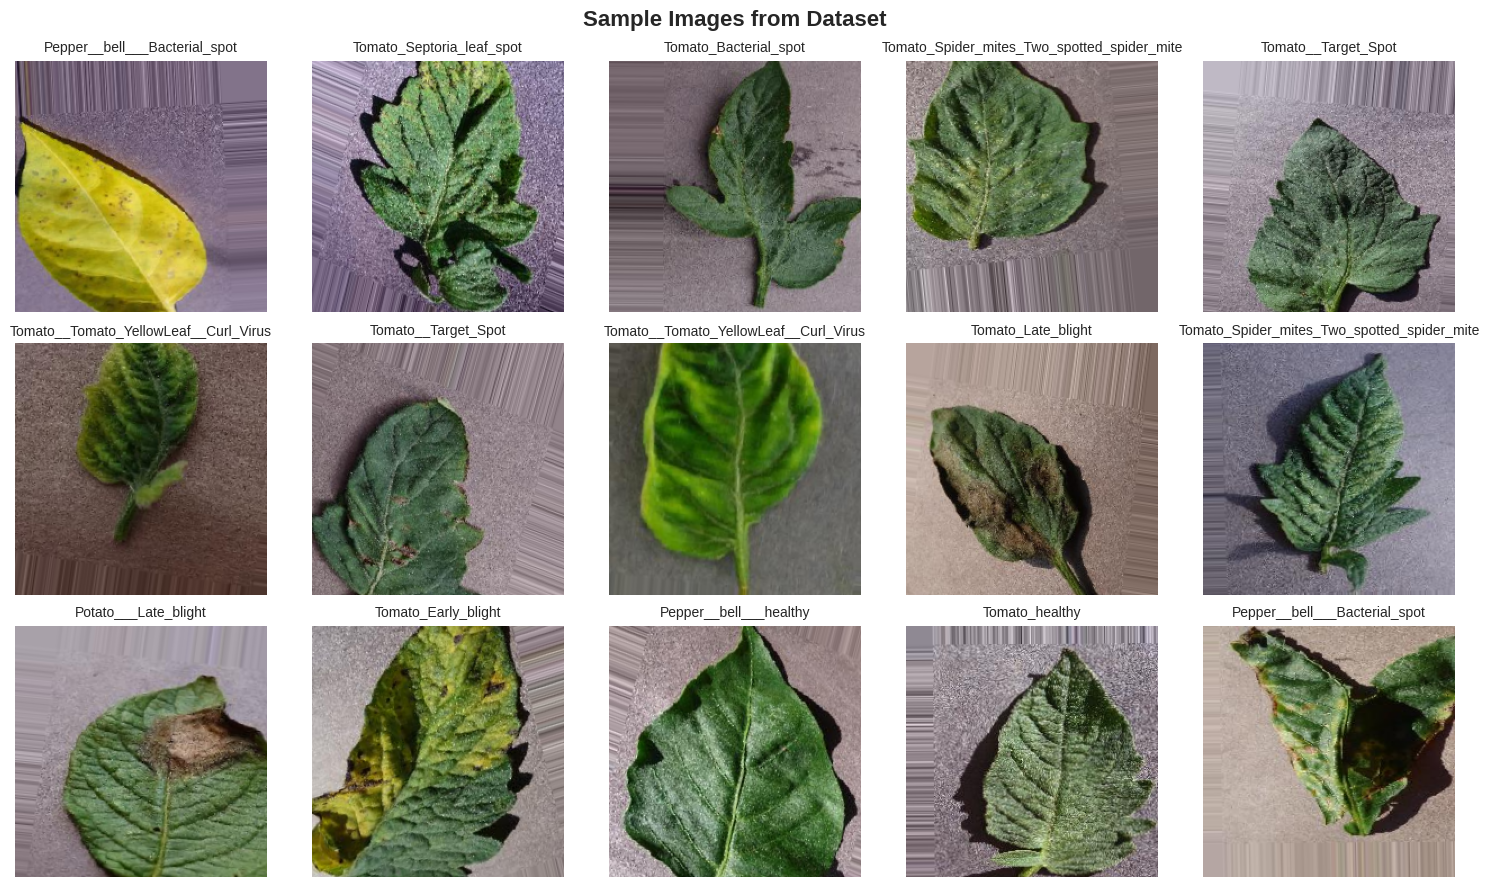

In [3]:
# Get a batch of images
sample_images, sample_labels = next(train_generator)

# Create reverse mapping for class indices
class_names = {v: k for k, v in train_generator.class_indices.items()}

# Plot sample images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i])
    label_idx = np.argmax(sample_labels[i])
    ax.set_title(class_names[label_idx], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4. Model 1: Transfer Learning WITHOUT Fine-Tuning

In this approach, we freeze all layers of the pre-trained MobileNetV2 base model and only train the new classification layers we add on top.

In [4]:
# Load pre-trained MobileNetV2 without top layers
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_no_finetune = Model(inputs=base_model.input, outputs=predictions)

# Display model summary
print('Model without fine-tuning:')
print(f'Total layers: {len(model_no_finetune.layers)}')
print(f'Trainable layers: {sum([layer.trainable for layer in model_no_finetune.layers])}')
model_no_finetune.summary()

I0000 00:00:1760393606.191798      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model without fine-tuning:
Total layers: 160
Trainable layers: 6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,049,039 (11.63 MB)

 Trainable params: 791,055 (3.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4.1 Compile and Train Model 1

In [5]:
# Compile the model
model_no_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print('Training Model 1 (WITHOUT fine-tuning)...')
history_no_finetune = model_no_finetune.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print('\nTraining completed!')

Training Model 1 (WITHOUT fine-tuning)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1760393617.789775      76 service.cc:148] XLA service 0x796edc143d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760393617.790520      76 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760393618.692512      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/517 ━━━━━━━━━━━━━━━━━━━━ 1:54:59 13s/step - accuracy: 0.0000e+00 - loss: 3.2687

I0000 00:00:1760393623.095280      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


517/517 ━━━━━━━━━━━━━━━━━━━━ 315s 584ms/step - accuracy: 0.5881 - loss: 1.2953 - val_accuracy: 0.8341 - val_loss: 0.4918 - learning_rate: 0.0010
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 191s 369ms/step - accuracy: 0.8012 - loss: 0.6037 - val_accuracy: 0.8588 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 188s 364ms/step - accuracy: 0.8337 - loss: 0.5239 - val_accuracy: 0.8714 - val_loss: 0.3895 - learning_rate: 0.0010
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 181s 350ms/step - accuracy: 0.8520 - loss: 0.4405 - val_accuracy: 0.8559 - val_loss: 0.4223 - learning_rate: 0.0010
Epoch 5/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 182s 352ms/step - accuracy: 0.8591 - loss: 0.4118 - val_accuracy: 0.8886 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 6/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 183s 353ms/step - accuracy: 0.8726 - loss: 0.3814 - val_accuracy: 0.8675 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 7/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 181s 350ms/step - accuracy: 0.8759 

## 5. Model 2: Transfer Learning WITH Fine-Tuning

Now we'll unfreeze the last few layers of MobileNetV2 to allow fine-tuning. This enables the model to adapt the learned features more specifically to our plant disease dataset.

In [6]:
# Load pre-trained MobileNetV2 without top layers
base_model_ft = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# First, freeze all layers
base_model_ft.trainable = False

# Add custom classification head
x = base_model_ft.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_finetune = Model(inputs=base_model_ft.input, outputs=predictions)

# Compile for initial training
model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with frozen base initially (few epochs)
print('Phase 1: Training top layers only...')
initial_epochs = 10
history_initial = model_finetune.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=initial_epochs,
    verbose=1
)

Phase 1: Training top layers only...
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 199s 365ms/step - accuracy: 0.5920 - loss: 1.2795 - val_accuracy: 0.8280 - val_loss: 0.5016
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 181s 350ms/step - accuracy: 0.8061 - loss: 0.5805 - val_accuracy: 0.8513 - val_loss: 0.4192
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 181s 349ms/step - accuracy: 0.8403 - loss: 0.4796 - val_accuracy: 0.8668 - val_loss: 0.4143
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 182s 352ms/step - accuracy: 0.8497 - loss: 0.4553 - val_accuracy: 0.8629 - val_loss: 0.3885
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 185s 357ms/step - accuracy: 0.8615 - loss: 0.4102 - val_accuracy: 0.8819 - val_loss: 0.3550
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 183s 354ms/step - accuracy: 0.8695 - loss: 0.3869 - val_accuracy: 0.8777 - val_loss: 0.3627
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 182s 351ms/step - accuracy: 0.8682 - loss: 0.3890 - val_accuracy: 0.8816 - val_loss: 0.3456
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━

### 5.1 Unfreeze Layers and Fine-Tune

Now we unfreeze the last 30 layers of MobileNetV2 and continue training with a lower learning rate.

In [7]:
# Unfreeze the base model
base_model_ft.trainable = True

# Print total layers in base model
print(f'Total layers in MobileNetV2: {len(base_model_ft.layers)}')

# Fine-tune from layer 100 onwards
fine_tune_at = 100

# Freeze layers before fine_tune_at
for layer in base_model_ft.layers[:fine_tune_at]:
    layer.trainable = False

# Count trainable layers
trainable_count = sum([layer.trainable for layer in model_finetune.layers])
print(f'Trainable layers after unfreezing: {trainable_count}')

# Recompile with lower learning rate
model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
print('\nPhase 2: Fine-tuning the model...')
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model_finetune.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1],
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print('\nFine-tuning completed!')

Total layers in MobileNetV2: 154
Trainable layers after unfreezing: 60

Phase 2: Fine-tuning the model...
Epoch 10/25


E0000 00:00:1760398911.623998      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760398911.820363      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


517/517 ━━━━━━━━━━━━━━━━━━━━ 224s 382ms/step - accuracy: 0.7977 - loss: 0.7406 - val_accuracy: 0.6844 - val_loss: 1.8065 - learning_rate: 1.0000e-04
Epoch 11/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 182s 352ms/step - accuracy: 0.9189 - loss: 0.2649 - val_accuracy: 0.7902 - val_loss: 0.9092 - learning_rate: 1.0000e-04
Epoch 12/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 183s 354ms/step - accuracy: 0.9424 - loss: 0.1801 - val_accuracy: 0.8508 - val_loss: 0.5828 - learning_rate: 1.0000e-04
Epoch 13/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 184s 355ms/step - accuracy: 0.9591 - loss: 0.1280 - val_accuracy: 0.9090 - val_loss: 0.3807 - learning_rate: 1.0000e-04
Epoch 14/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 192s 372ms/step - accuracy: 0.9565 - loss: 0.1391 - val_accuracy: 0.9420 - val_loss: 0.2218 - learning_rate: 1.0000e-04
Epoch 15/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 195s 377ms/step - accuracy: 0.9698 - loss: 0.1011 - val_accuracy: 0.9583 - val_loss: 0.1508 - learning_rate: 1.0000e-04
Epoch 16/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 194s 

### 5.2 Combine Training Histories

In [8]:
# Combine the two training phases for the fine-tuned model
acc_ft = history_initial.history['accuracy'] + history_finetune.history['accuracy']
val_acc_ft = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss_ft = history_initial.history['loss'] + history_finetune.history['loss']
val_loss_ft = history_initial.history['val_loss'] + history_finetune.history['val_loss']

print(f'Total epochs trained (with fine-tuning): {len(acc_ft)}')

Total epochs trained (with fine-tuning): 26


## 6. Performance Comparison

Let's visualize and compare the training performance of both models.

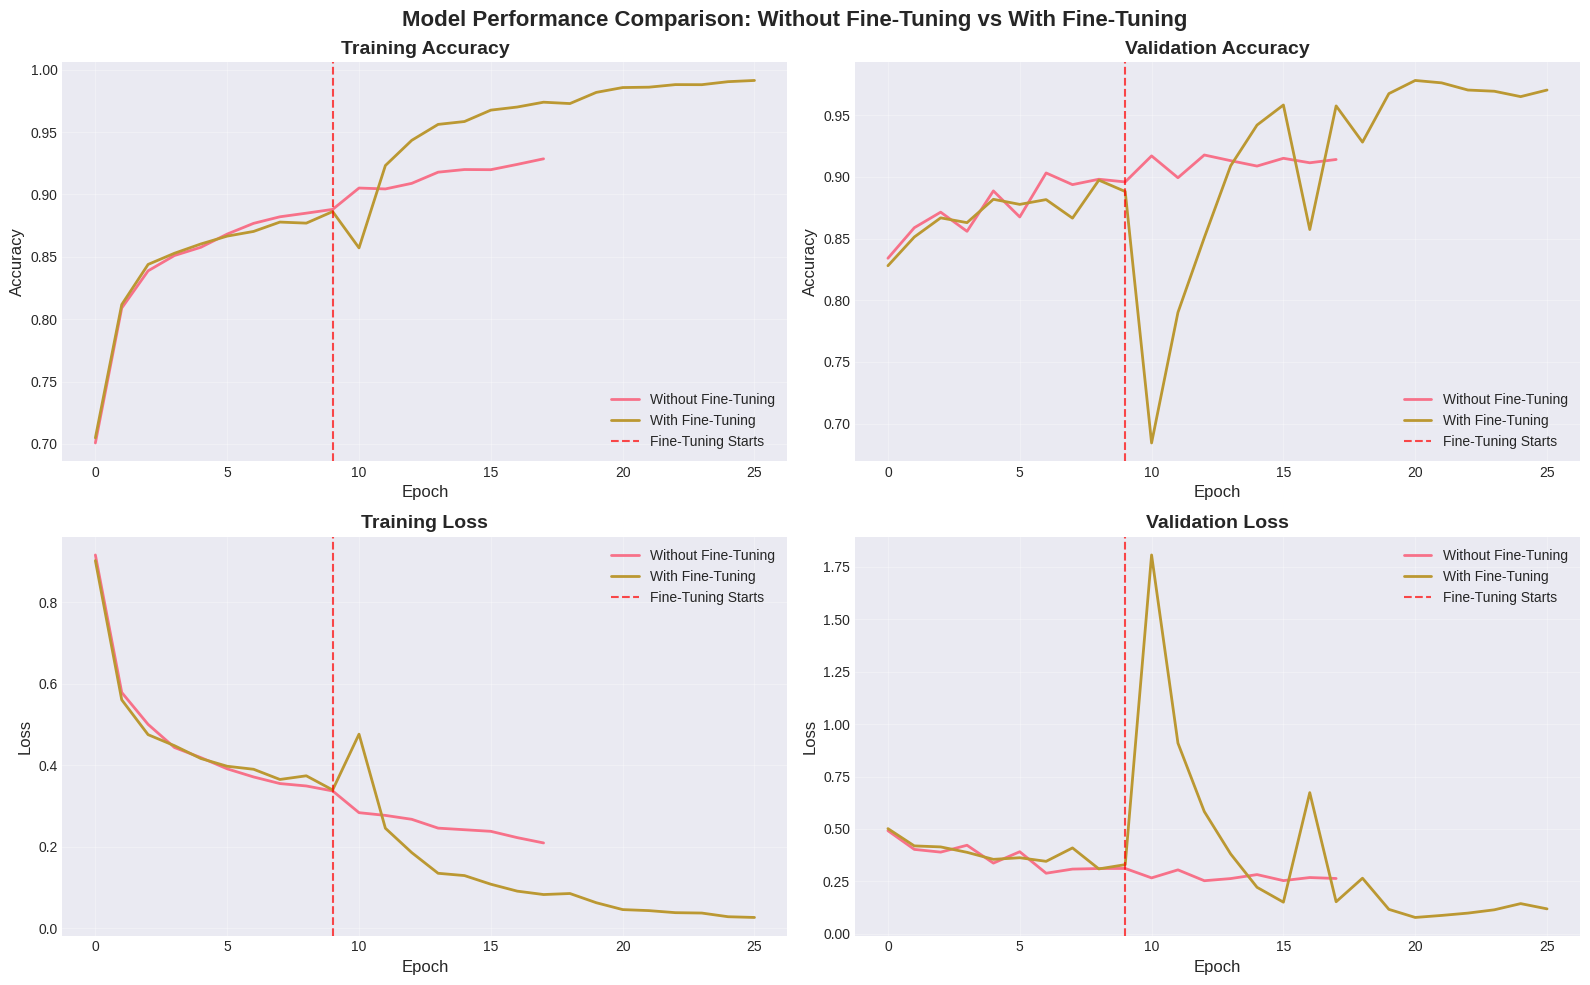

In [9]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Performance Comparison: Without Fine-Tuning vs With Fine-Tuning', 
             fontsize=16, fontweight='bold')

# Plot 1: Training Accuracy
axes[0, 0].plot(history_no_finetune.history['accuracy'], label='Without Fine-Tuning', linewidth=2)
axes[0, 0].plot(acc_ft, label='With Fine-Tuning', linewidth=2)
axes[0, 0].axvline(x=initial_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-Tuning Starts')
axes[0, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
axes[0, 1].plot(history_no_finetune.history['val_accuracy'], label='Without Fine-Tuning', linewidth=2)
axes[0, 1].plot(val_acc_ft, label='With Fine-Tuning', linewidth=2)
axes[0, 1].axvline(x=initial_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-Tuning Starts')
axes[0, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(loc='lower right', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Loss
axes[1, 0].plot(history_no_finetune.history['loss'], label='Without Fine-Tuning', linewidth=2)
axes[1, 0].plot(loss_ft, label='With Fine-Tuning', linewidth=2)
axes[1, 0].axvline(x=initial_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-Tuning Starts')
axes[1, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend(loc='upper right', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Validation Loss
axes[1, 1].plot(history_no_finetune.history['val_loss'], label='Without Fine-Tuning', linewidth=2)
axes[1, 1].plot(val_loss_ft, label='With Fine-Tuning', linewidth=2)
axes[1, 1].axvline(x=initial_epochs-1, color='red', linestyle='--', alpha=0.7, label='Fine-Tuning Starts')
axes[1, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Loss', fontsize=12)
axes[1, 1].legend(loc='upper right', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.1 Final Accuracy Comparison

In [10]:
# Get final metrics
final_train_acc_no_ft = history_no_finetune.history['accuracy'][-1]
final_val_acc_no_ft = history_no_finetune.history['val_accuracy'][-1]
final_train_acc_ft = acc_ft[-1]
final_val_acc_ft = val_acc_ft[-1]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Without Fine-Tuning', 'With Fine-Tuning'],
    'Training Accuracy': [final_train_acc_no_ft, final_train_acc_ft],
    'Validation Accuracy': [final_val_acc_no_ft, final_val_acc_ft],
    'Training Loss': [history_no_finetune.history['loss'][-1], loss_ft[-1]],
    'Validation Loss': [history_no_finetune.history['val_loss'][-1], val_loss_ft[-1]]
})

print('\n' + '='*80)
print('FINAL PERFORMANCE COMPARISON')
print('='*80)
print(comparison_df.to_string(index=False))
print('='*80)

# Calculate improvement
accuracy_improvement = (final_val_acc_ft - final_val_acc_no_ft) * 100
print(f'\nValidation Accuracy Improvement: {accuracy_improvement:.2f}%')


FINAL PERFORMANCE COMPARISON
              Model  Training Accuracy  Validation Accuracy  Training Loss  Validation Loss
Without Fine-Tuning           0.928615             0.914119       0.209332         0.263826
   With Fine-Tuning           0.991463             0.970403       0.026569         0.118930

Validation Accuracy Improvement: 5.63%


### 6.2 Visual Comparison of Final Metrics

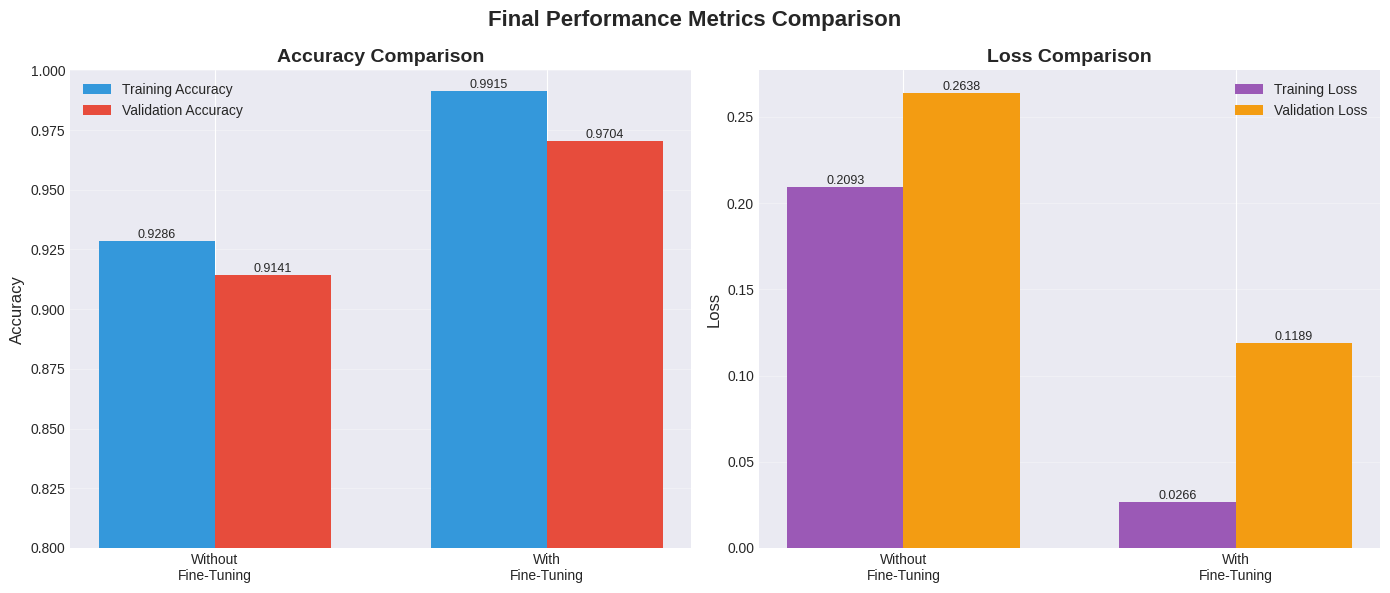

In [11]:
# Create bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Final Performance Metrics Comparison', fontsize=16, fontweight='bold')

# Accuracy comparison
models = ['Without\nFine-Tuning', 'With\nFine-Tuning']
train_accs = [final_train_acc_no_ft, final_train_acc_ft]
val_accs = [final_val_acc_no_ft, final_val_acc_ft]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_accs, width, label='Training Accuracy', color='#3498db')
bars2 = axes[0].bar(x + width/2, val_accs, width, label='Validation Accuracy', color='#e74c3c')

axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend(fontsize=10)
axes[0].set_ylim([0.8, 1.0])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Loss comparison
train_losses = [history_no_finetune.history['loss'][-1], loss_ft[-1]]
val_losses = [history_no_finetune.history['val_loss'][-1], val_loss_ft[-1]]

bars3 = axes[1].bar(x - width/2, train_losses, width, label='Training Loss', color='#9b59b6')
bars4 = axes[1].bar(x + width/2, val_losses, width, label='Validation Loss', color='#f39c12')

axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Save Models

In [12]:
# Save both models
model_no_finetune.save('plant_disease_no_finetune.h5')
model_finetune.save('plant_disease_with_finetune.h5')

print('Models saved successfully!')
print('- plant_disease_no_finetune.h5')
print('- plant_disease_with_finetune.h5')

Models saved successfully!
- plant_disease_no_finetune.h5
- plant_disease_with_finetune.h5


## 8. Visualize Predictions

Let's compare the predictions of both models on validation images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


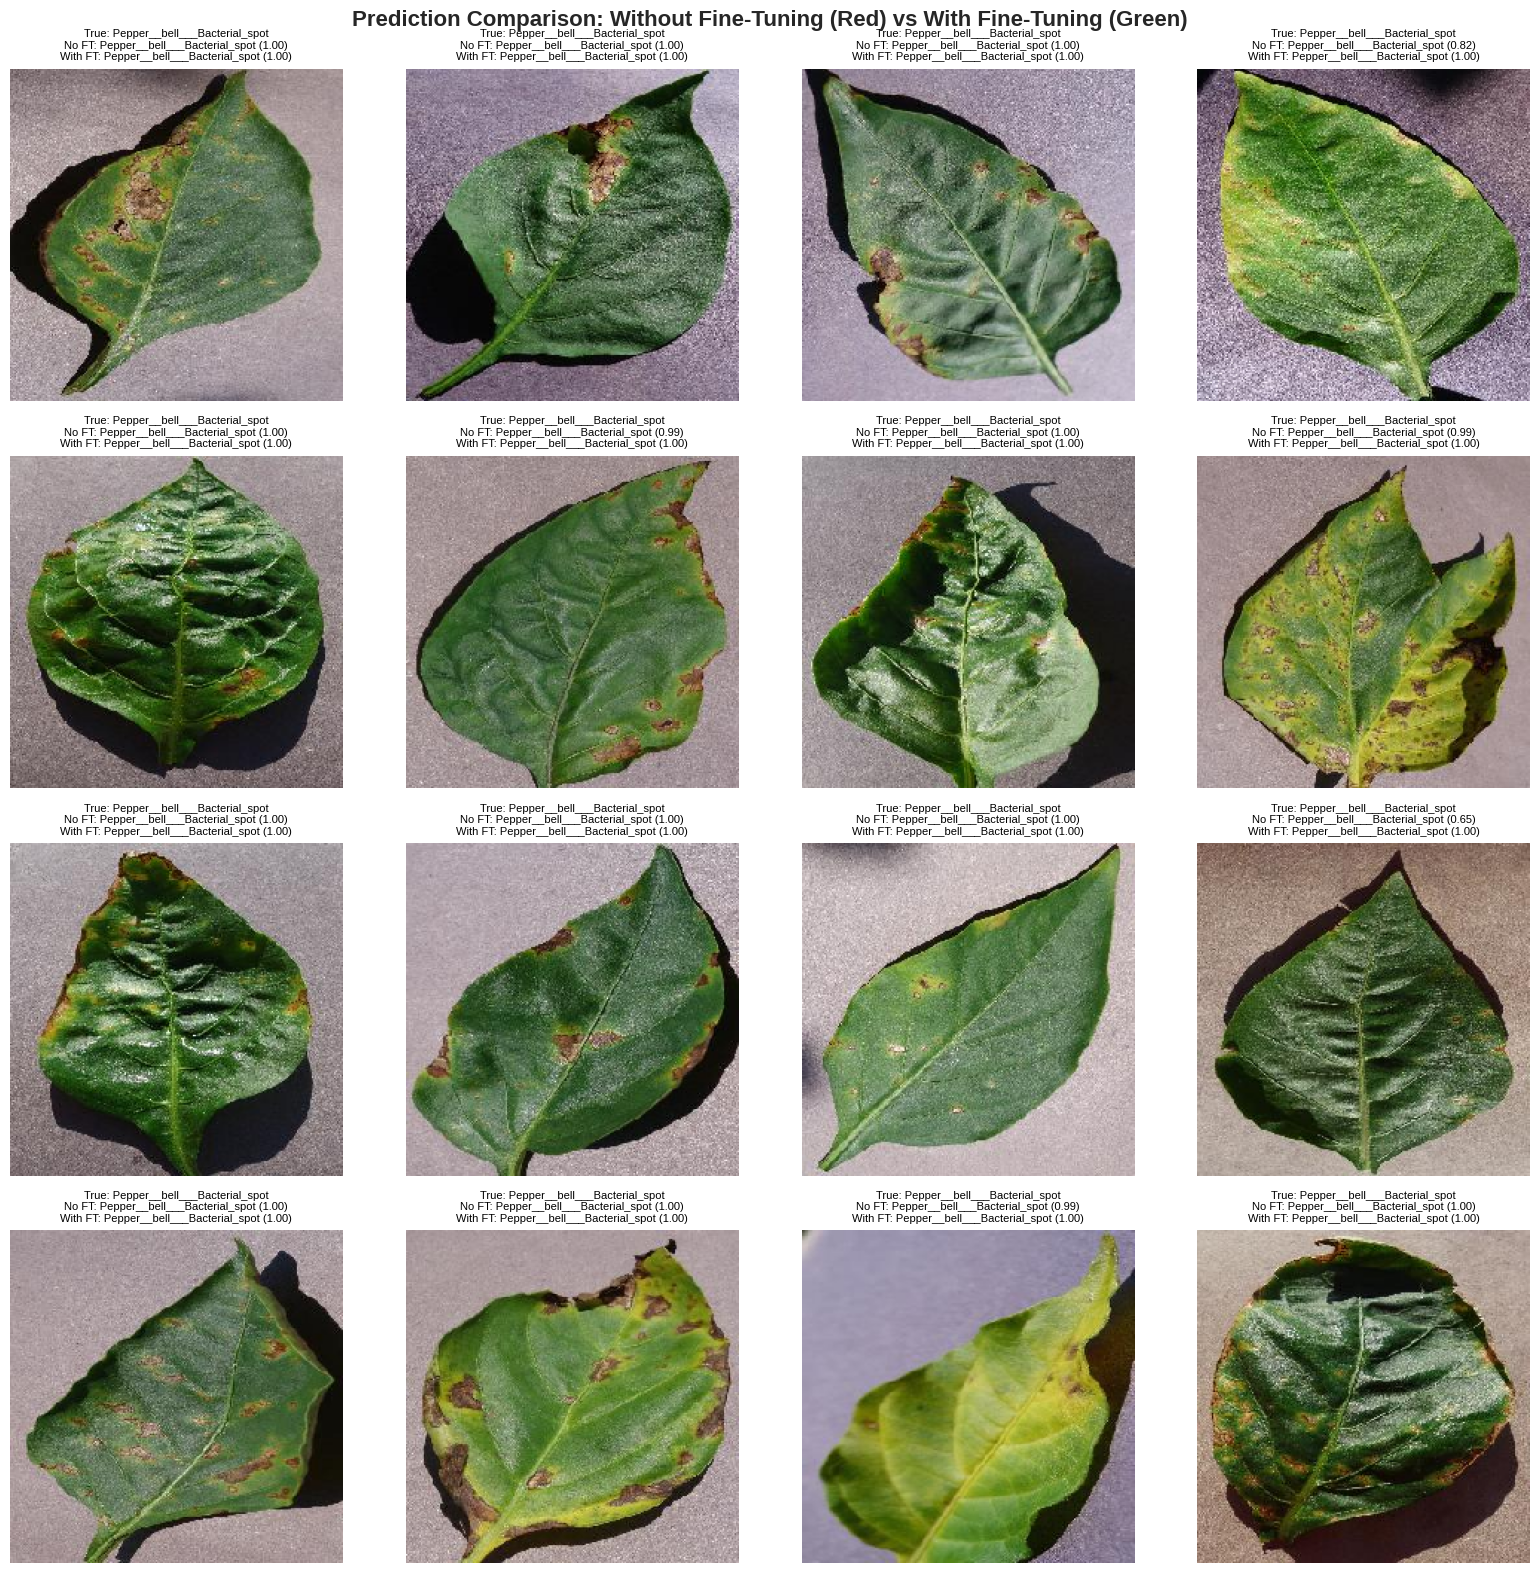

In [13]:
# Get a batch of validation images
val_images, val_labels = next(valid_generator)

# Make predictions with both models
pred_no_ft = model_no_finetune.predict(val_images)
pred_ft = model_finetune.predict(val_images)

# Plot predictions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Prediction Comparison: Without Fine-Tuning (Red) vs With Fine-Tuning (Green)', 
             fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < len(val_images):
        ax.imshow(val_images[i])
        
        true_label = class_names[np.argmax(val_labels[i])]
        pred_label_no_ft = class_names[np.argmax(pred_no_ft[i])]
        pred_label_ft = class_names[np.argmax(pred_ft[i])]
        
        conf_no_ft = np.max(pred_no_ft[i])
        conf_ft = np.max(pred_ft[i])
        
        # Color coding: green for correct, red for incorrect
        color_no_ft = 'green' if pred_label_no_ft == true_label else 'red'
        color_ft = 'green' if pred_label_ft == true_label else 'red'
        
        title = f'True: {true_label}\n'
        title += f'No FT: {pred_label_no_ft} ({conf_no_ft:.2f})\n'
        title += f'With FT: {pred_label_ft} ({conf_ft:.2f})'
        
        ax.set_title(title, fontsize=8, color='black')
        ax.axis('off')

plt.tight_layout()
plt.show()

## 9. Conclusion

### Key Findings:

1. **Without Fine-Tuning**: The model with frozen base layers learns quickly but may plateau earlier since it only adapts the final classification layers.

2. **With Fine-Tuning**: By unfreezing and retraining the last layers of MobileNetV2, the model can better adapt to the specific features of plant disease images, typically resulting in higher accuracy.

3. **Trade-offs**:
   - Fine-tuning requires more computational resources and training time
   - Fine-tuning can lead to overfitting if not done carefully (use lower learning rates)
   - For small datasets, transfer learning without fine-tuning might be safer

4. **Best Practice**: Start with frozen base model, train the classification head, then fine-tune with a lower learning rate for optimal results.